# Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np

In [2]:
!git clone https://github.com/dknayakbu/ERA-V1-Assignments.git

Cloning into 'ERA-V1-Assignments'...
remote: Enumerating objects: 158, done.
remote: Counting objects: 100% (158/158), done.
remote: Compressing objects: 100% (129/129), done.
remote: Total 158 (delta 68), reused 76 (delta 25), pack-reused 0
Receiving objects: 100% (158/158), 2.27 MiB | 9.43 MiB/s, done.
Resolving deltas: 100% (68/68), done.


## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise.


In [3]:
cd ERA-V1-Assignments/S11

/content/ERA-V1-Assignments/S11


In [4]:
!ls

main.py  models  utils.py


In [5]:
from models.model import *
from main import *

/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/dropout/cutout.py:50: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(


CUDA Available? True


100%|██████████| 170498071/170498071 [00:03<00:00, 46900612.10it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

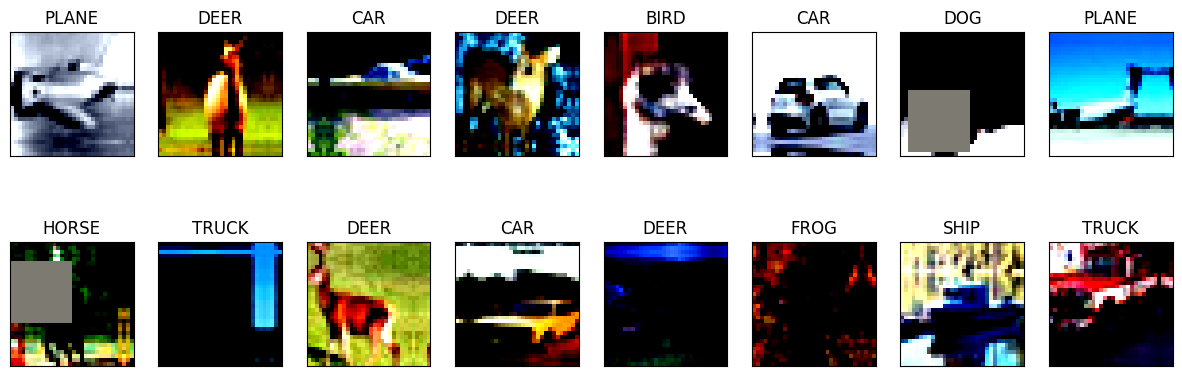

In [6]:

print_samples(train_loader, class_map)

# The model
Let's start with the model we first saw

# Model Params
Can't emphasize on how important viewing Model Summary is.
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [7]:
!pip install torchsummary
from torchsummary import summary

summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

## Finding LR Max

In [8]:
!pip install torch_lr_finder

/usr/local/lib/python3.10/dist-packages/torch_lr_finder/lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


  0%|          | 0/200 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 7.66E-03


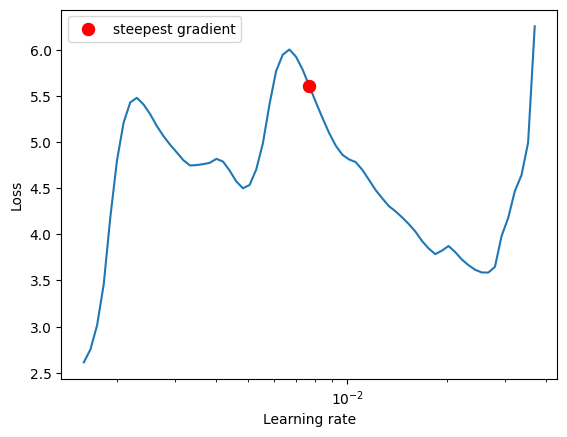

Best LR 0.001


In [9]:
from torch_lr_finder import LRFinder

lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, val_loader=test_loader, end_lr=10, num_iter=200, step_mode="exp")

lr_finder.plot()
best_lr = lr_finder.history['lr'][lr_finder.history['loss'].index(lr_finder.best_loss)]
print('Best LR',best_lr)
lr_finder.reset()

In [10]:
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr = best_lr,
                                                    steps_per_epoch = len(train_loader), epochs = EPOCHS,
                                                    pct_start = 5/EPOCHS, div_factor = 100, three_phase = False,
                                                    final_div_factor = 100, anneal_strategy = 'linear')

In [11]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []

for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    loss, acc = train(model, device, train_loader, optimizer, epoch)
    train_losses.extend(loss)
    train_acc.extend(acc)
    scheduler.step()
    loss, acc = test(model, device, test_loader)
    test_losses.extend(loss)
    test_acc.extend(acc)

EPOCH: 0


Loss=-8.348092079162598 Batch_id=390 Accuracy=27.22: 100%|██████████| 391/391 [00:47<00:00,  8.29it/s]



Test set: Average loss: -8.9889, Accuracy: 3718/10000 (37.18%)

EPOCH: 1


Loss=-13.658432006835938 Batch_id=390 Accuracy=40.79: 100%|██████████| 391/391 [00:45<00:00,  8.53it/s]



Test set: Average loss: -14.1183, Accuracy: 4674/10000 (46.74%)

EPOCH: 2


Loss=-17.852144241333008 Batch_id=390 Accuracy=47.22: 100%|██████████| 391/391 [00:46<00:00,  8.47it/s]



Test set: Average loss: -18.8614, Accuracy: 5065/10000 (50.65%)

EPOCH: 3


Loss=-20.194150924682617 Batch_id=390 Accuracy=50.90: 100%|██████████| 391/391 [00:46<00:00,  8.48it/s]



Test set: Average loss: -23.5322, Accuracy: 5295/10000 (52.95%)

EPOCH: 4


Loss=-25.949024200439453 Batch_id=390 Accuracy=53.79: 100%|██████████| 391/391 [00:46<00:00,  8.47it/s]



Test set: Average loss: -27.8278, Accuracy: 5529/10000 (55.29%)

EPOCH: 5


Loss=-30.83526611328125 Batch_id=390 Accuracy=55.82: 100%|██████████| 391/391 [00:46<00:00,  8.49it/s]



Test set: Average loss: -31.2832, Accuracy: 5802/10000 (58.02%)

EPOCH: 6


Loss=-33.5245361328125 Batch_id=390 Accuracy=57.52: 100%|██████████| 391/391 [00:45<00:00,  8.51it/s]



Test set: Average loss: -36.9181, Accuracy: 5947/10000 (59.47%)

EPOCH: 7


Loss=-39.903602600097656 Batch_id=390 Accuracy=59.00: 100%|██████████| 391/391 [00:45<00:00,  8.51it/s]



Test set: Average loss: -41.5162, Accuracy: 5965/10000 (59.65%)

EPOCH: 8


Loss=-42.468833923339844 Batch_id=390 Accuracy=60.06: 100%|██████████| 391/391 [00:45<00:00,  8.51it/s]



Test set: Average loss: -45.9304, Accuracy: 6018/10000 (60.18%)

EPOCH: 9


Loss=-49.49666213989258 Batch_id=390 Accuracy=60.98: 100%|██████████| 391/391 [00:45<00:00,  8.51it/s]



Test set: Average loss: -50.7896, Accuracy: 6128/10000 (61.28%)

EPOCH: 10


Loss=-54.692359924316406 Batch_id=390 Accuracy=61.56: 100%|██████████| 391/391 [00:45<00:00,  8.51it/s]



Test set: Average loss: -57.7965, Accuracy: 6265/10000 (62.65%)

EPOCH: 11


Loss=-58.20646286010742 Batch_id=390 Accuracy=62.64: 100%|██████████| 391/391 [00:45<00:00,  8.52it/s]



Test set: Average loss: -63.1021, Accuracy: 6322/10000 (63.22%)

EPOCH: 12


Loss=-66.6490249633789 Batch_id=390 Accuracy=63.19: 100%|██████████| 391/391 [00:45<00:00,  8.54it/s]



Test set: Average loss: -70.2397, Accuracy: 6413/10000 (64.13%)

EPOCH: 13


Loss=-74.10527801513672 Batch_id=390 Accuracy=63.99: 100%|██████████| 391/391 [00:45<00:00,  8.52it/s]



Test set: Average loss: -75.8298, Accuracy: 6379/10000 (63.79%)

EPOCH: 14


Loss=-79.94081115722656 Batch_id=390 Accuracy=64.56: 100%|██████████| 391/391 [00:46<00:00,  8.49it/s]



Test set: Average loss: -82.3945, Accuracy: 6408/10000 (64.08%)

EPOCH: 15


Loss=-89.30684661865234 Batch_id=390 Accuracy=65.00: 100%|██████████| 391/391 [00:46<00:00,  8.50it/s]



Test set: Average loss: -90.2219, Accuracy: 6459/10000 (64.59%)

EPOCH: 16


Loss=-96.66923522949219 Batch_id=390 Accuracy=65.41: 100%|██████████| 391/391 [00:45<00:00,  8.53it/s]



Test set: Average loss: -97.6025, Accuracy: 6542/10000 (65.42%)

EPOCH: 17


Loss=-102.21519470214844 Batch_id=390 Accuracy=66.01: 100%|██████████| 391/391 [00:45<00:00,  8.52it/s]



Test set: Average loss: -103.9684, Accuracy: 6592/10000 (65.92%)

EPOCH: 18


Loss=-113.39399719238281 Batch_id=390 Accuracy=66.55: 100%|██████████| 391/391 [00:45<00:00,  8.54it/s]



Test set: Average loss: -112.6640, Accuracy: 6633/10000 (66.33%)

EPOCH: 19


Loss=-120.7132797241211 Batch_id=390 Accuracy=66.85: 100%|██████████| 391/391 [00:45<00:00,  8.50it/s]



Test set: Average loss: -121.5926, Accuracy: 6581/10000 (65.81%)



Text(0.5, 1.0, 'Test Accuracy')

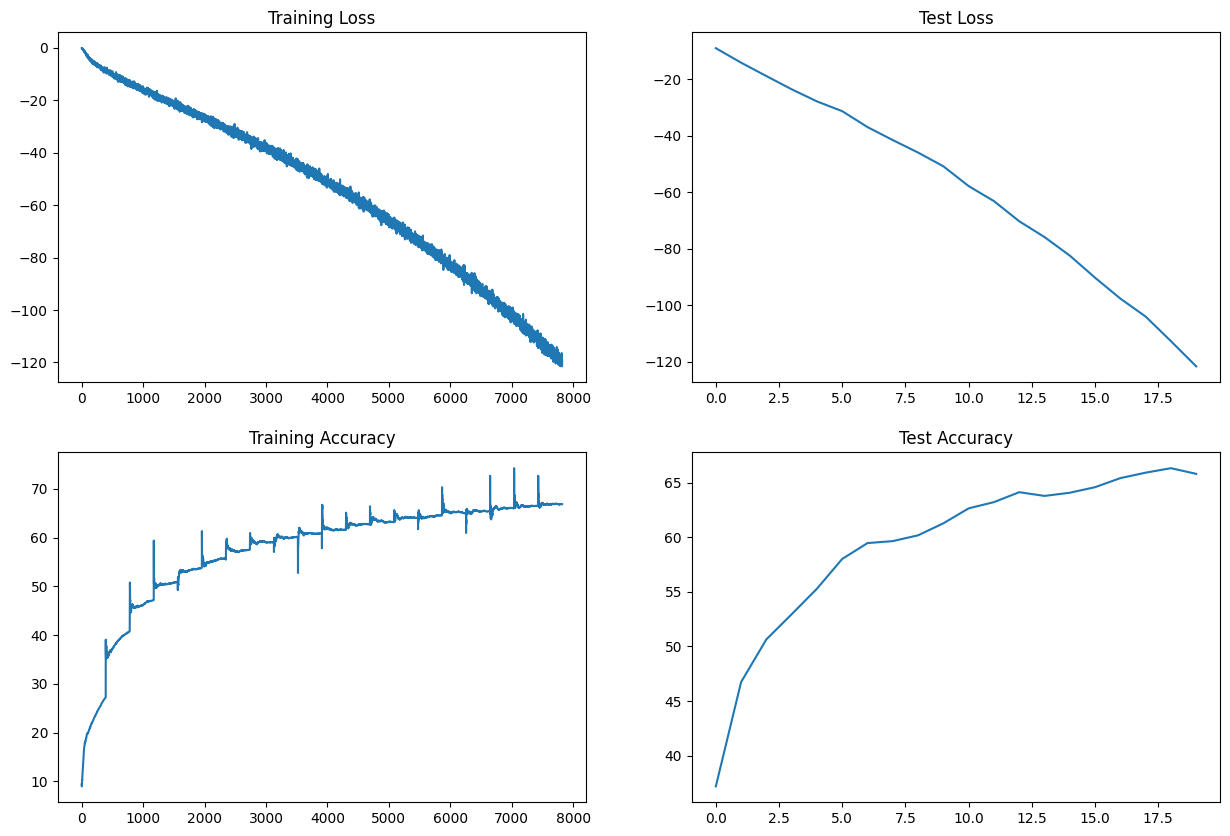

In [12]:
t = [t_items.item() for t_items in train_losses]
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [13]:
incorrect = get_incorrrect_predictions(model, test_loader, device)

Total Incorrect Predictions 3419


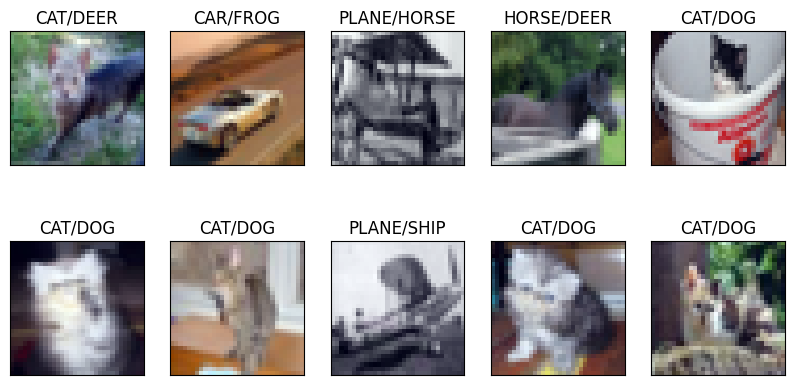

In [14]:
plot_incorrect_predictions(incorrect, class_map)

# GradCam

In [17]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 24.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.4.8-py3-none-any.whl size=38247 sha256=99b65ed1aadec105a863e7a515c4bd1b347192b86ffc70326f34d9ddffff747f
  Stored in directory: /root/.cache/pip/wheels/f8/04/36/94ff3c8a4215826a21946b34c01180817e606989fdf53f7cd6
Successfully built grad-cam


In [22]:
from pytorch_grad_cam import GradCAM

target_layer = [model.layer4[-1].conv2] # Choose the target layer for visualization
gradcam = GradCAM(model=model, target_layers=target_layer)

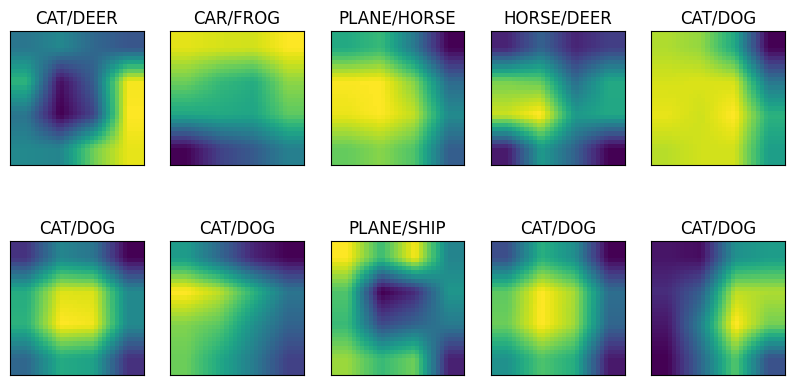

In [64]:
classes = list(class_map.keys())
count = 10

fig = plt.figure(figsize=(10, 5))
for i, (d, t, p, o) in enumerate(incorrect):
    ax = fig.add_subplot(int(count/5), 5, i + 1, xticks=[], yticks=[])
    ax.set_title(f'{classes[t.item()]}/{classes[p.item()]}')
    # show_image = d.cpu().numpy().transpose(1, 2, 0)
    # Rescale the pixel values to [0, 1]
    cam = gradcam(incorrect[i][0].unsqueeze(0).to('cuda'))[0]
    show_image = (cam - np.min(cam)) / (np.max(cam) - np.min(cam))
    plt.imshow(show_image)
    if i+1 == 5*(count/5):
        break